In [1]:
'''from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = '/content/drive/MyDrive/trafic_32.zip'
extract_path = '/content/trafic_32'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\nimport zipfile\n\nzip_path = '/content/drive/MyDrive/trafic_32.zip'\nextract_path = '/content/trafic_32'\n\nwith zipfile.ZipFile(zip_path, 'r') as zip_ref:\n    zip_ref.extractall(extract_path)"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [4]:
image_size = 32
data_dir = './trafic_32/'
batch_size = 64
val_split = 0.1

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(dataset.class_to_idx)

total_size = len(dataset)
val_size = int(total_size * val_split)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loadery
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

{'00000': 0, '00001': 1, '00002': 2, '00003': 3, '00004': 4, '00005': 5, '00006': 6, '00007': 7, '00008': 8, '00009': 9, '00010': 10, '00011': 11, '00012': 12, '00013': 13, '00014': 14, '00015': 15, '00016': 16, '00017': 17, '00018': 18, '00019': 19, '00020': 20, '00021': 21, '00022': 22, '00023': 23, '00024': 24, '00025': 25, '00026': 26, '00027': 27, '00028': 28, '00029': 29, '00030': 30, '00031': 31, '00032': 32, '00033': 33, '00034': 34, '00035': 35, '00036': 36, '00037': 37, '00038': 38, '00039': 39, '00040': 40, '00041': 41, '00042': 42}


In [6]:
print(dataset[1])
print(dataset[0][0].shape)

(tensor([[[-0.4275, -0.3804, -0.4039,  ..., -0.4353, -0.3882, -0.4824],
         [-0.5294, -0.4588, -0.3176,  ..., -0.3176, -0.4118, -0.4275],
         [-0.5451, -0.4588, -0.3176,  ..., -0.1843, -0.3647, -0.4667],
         ...,
         [ 0.2314,  0.2235,  0.0902,  ..., -0.3804, -0.3333, -0.2314],
         [-0.1373, -0.1608, -0.1765,  ..., -0.4039, -0.2706, -0.2000],
         [-0.4275, -0.3412, -0.2157,  ..., -0.4510, -0.2627, -0.2471]],

        [[-0.4196, -0.3725, -0.4196,  ..., -0.4275, -0.3725, -0.4667],
         [-0.4824, -0.4431, -0.3255,  ..., -0.3569, -0.4275, -0.4275],
         [-0.4431, -0.3961, -0.3490,  ..., -0.3412, -0.4510, -0.5137],
         ...,
         [ 0.0118,  0.0667,  0.0431,  ..., -0.3647, -0.3647, -0.2784],
         [-0.2157, -0.2392, -0.2706,  ..., -0.3255, -0.2157, -0.1373],
         [-0.4275, -0.3725, -0.3333,  ..., -0.3647, -0.1529, -0.1373]],

        [[-0.4039, -0.3569, -0.3961,  ..., -0.3882, -0.3804, -0.4902],
         [-0.4980, -0.4667, -0.3412,  ..., -

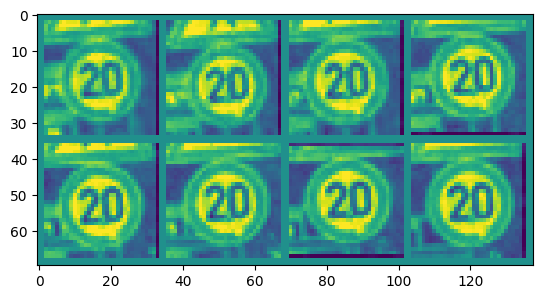

In [7]:
def get_train_images(num):
    return torch.stack([dataset[i][0] for i in range(10,10+num)], dim=0)

plt.imshow(torchvision.utils.make_grid(get_train_images(8), nrow=4)[0]);

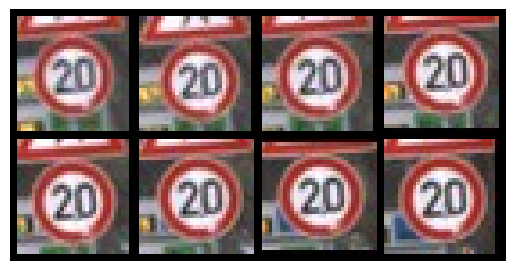

In [8]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def get_train_images(num):
    images = torch.stack([dataset[i][0] for i in range(10, 10 + num)], dim=0)
    images = images * 0.5 + 0.5
    return images

images = get_train_images(8)

grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

grid = grid.permute(1, 2, 0)

plt.imshow(grid)
plt.axis('off')
plt.show()

In [9]:
def corrupt(x, amount):
    noise = torch.randn_like(x)
    amount = amount.view(-1, 1, 1, 1)
    noisy_x = x * (1 - amount) + noise * amount
    return noisy_x.clamp(-1, 1)

Input shape: torch.Size([43, 3, 32, 32])


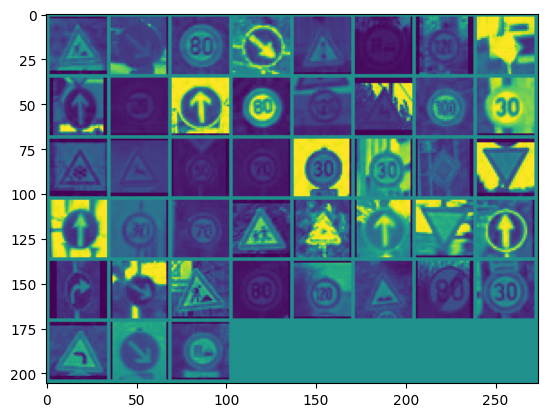

In [10]:
x, y = next(iter(train_loader))
x = x[:43]
print('Input shape:', x.shape)
plt.imshow(torchvision.utils.make_grid(x)[0]);

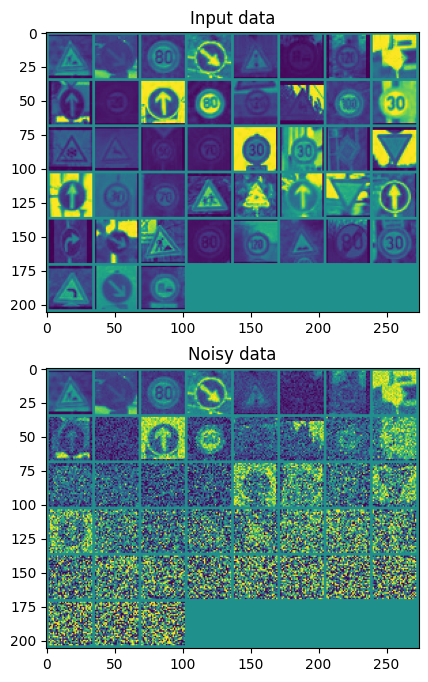

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0])

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Noisy data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0]);

In [12]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]  # [B, D/2]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # [B, D]
        return emb

In [13]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_classes=43, emb_dim=128):
        super().__init__()
        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim * 2),
            nn.SiLU(),
            nn.Linear(emb_dim * 2, emb_dim)
        )
        self.class_embedding = nn.Embedding(num_classes, emb_dim)
        self.cond_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
        ])

        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128 + emb_dim, 128, kernel_size=5, padding=2),
                nn.BatchNorm2d(128),
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),
            ),
            nn.Sequential(
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
                nn.BatchNorm2d(out_channels),
            ),
        ])

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        self.tanh = nn.Tanh()

    def forward(self, x, y, t):
        t_emb = self.time_embedding(t)
        y_emb = self.class_embedding(y)
        cond_emb = self.cond_proj(t_emb + y_emb)

        h = []
        for i, l in enumerate(self.down_layers):
            x = l(x)
            x = self.act(x)
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        cond = cond_emb[:, :, None, None].expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, cond], dim=1)

        for i, l in enumerate(self.up_layers):
            if i > 1:
                x = self.upscale(x)
                x += h.pop()
            x = l(x)
            x = self.act(x)
        return x

In [14]:
net = BasicUNet().to(device)
net

BasicUNet(
  (time_embedding): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): SiLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
  (class_embedding): Embedding(43, 128)
  (cond_proj): Sequential(
    (0): SiLU()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(


In [15]:
def tensor_to_image(tensor, normalize=True):
    tensor = tensor.cpu().detach()
    print(f"Tensor min: {tensor.min().item():.4f}, max: {tensor.max().item():.4f}")
    if normalize:
        tensor = (tensor + 1) / 2
        tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0)
    return tensor.numpy()

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.55it/s]


Finished epoch 0. Average loss for this epoch: 0.166631
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9951
Sample 2:
Tensor min: -1.0000, max: 0.7804
Tensor min: -1.0000, max: 0.8444
Tensor min: -0.2715, max: 0.9699
Sample 3:
Tensor min: -0.9294, max: -0.4510
Tensor min: -1.0000, max: -0.1727
Tensor min: -0.2715, max: -0.2551


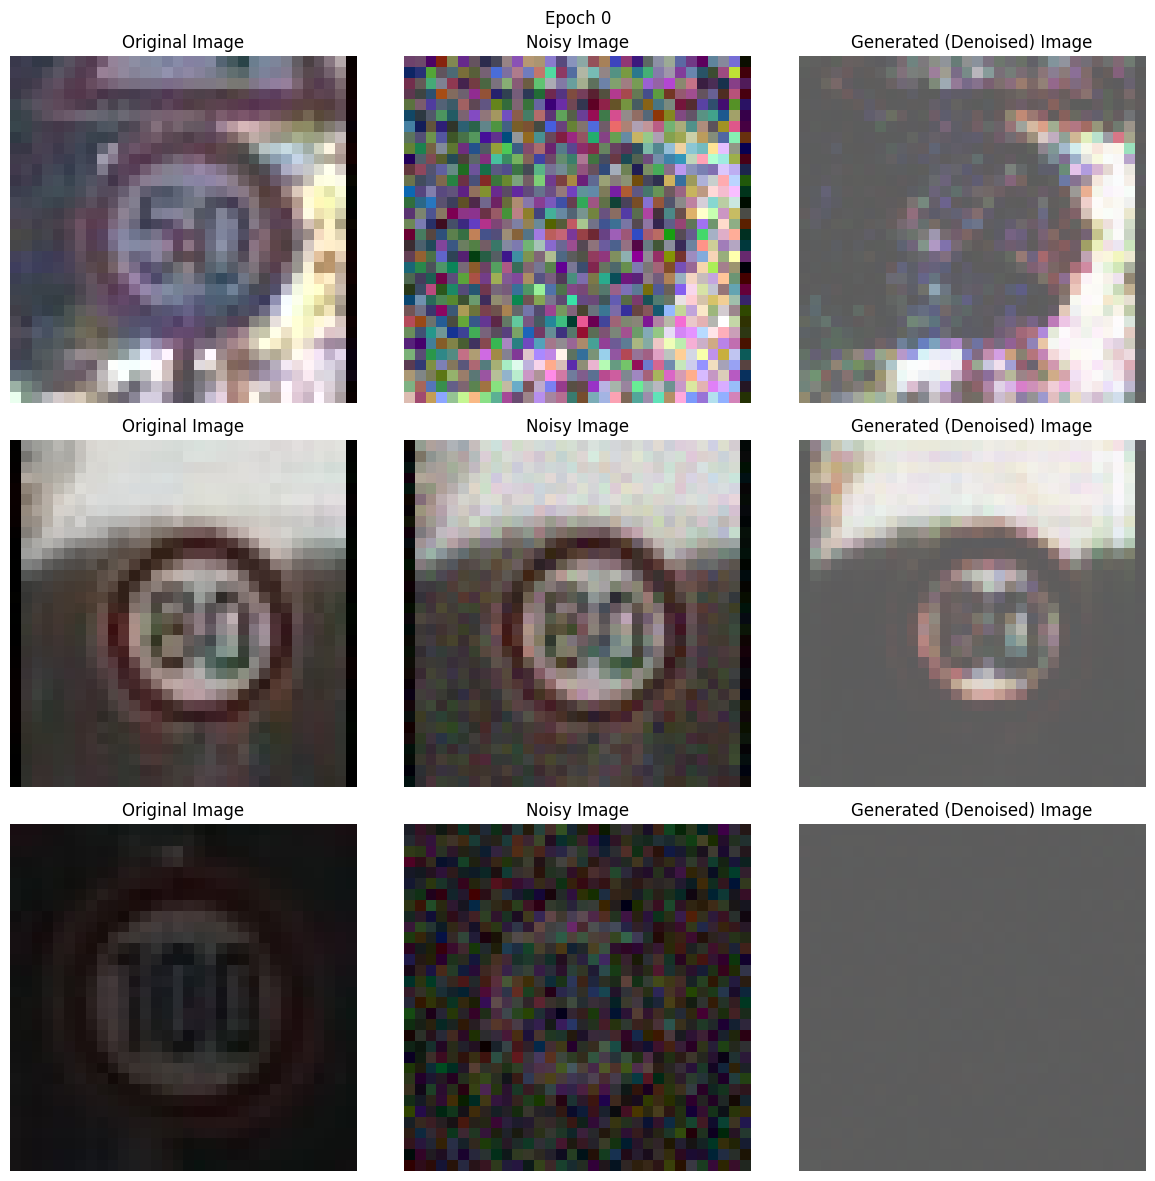

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.45it/s]


Finished epoch 1. Average loss for this epoch: 0.157454
Sample 1:
Tensor min: -0.9294, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9861
Sample 2:
Tensor min: -1.0000, max: 0.1686
Tensor min: -1.0000, max: 0.2644
Tensor min: -0.2715, max: -0.2195
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9946


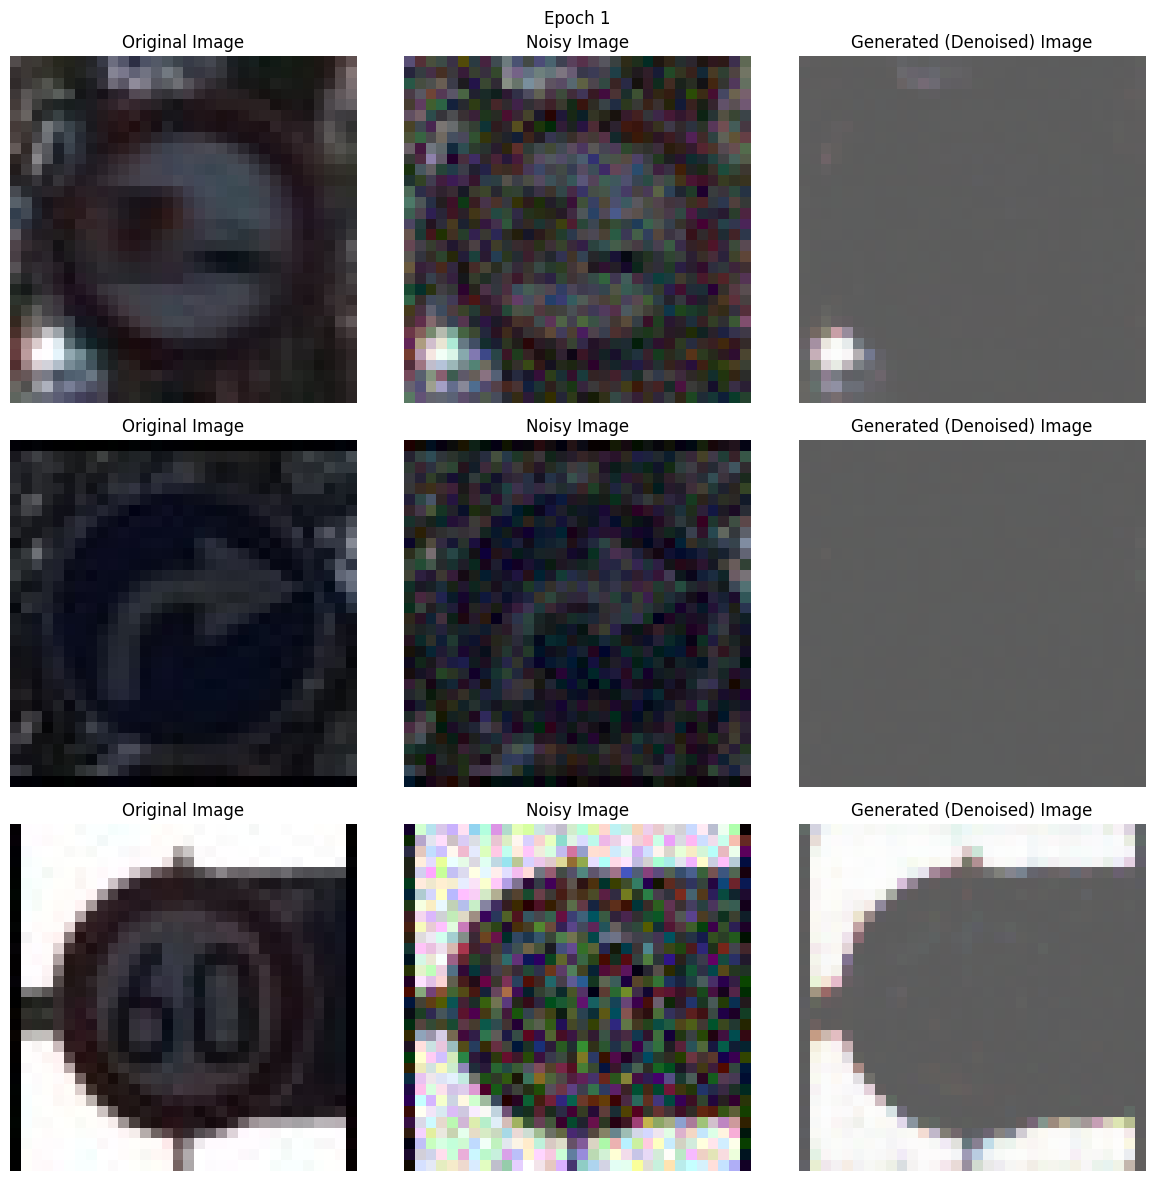

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.50it/s]


Finished epoch 2. Average loss for this epoch: 0.156029
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9756
Sample 2:
Tensor min: -0.9765, max: -0.4039
Tensor min: -1.0000, max: -0.2145
Tensor min: -0.2715, max: -0.2646
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9901


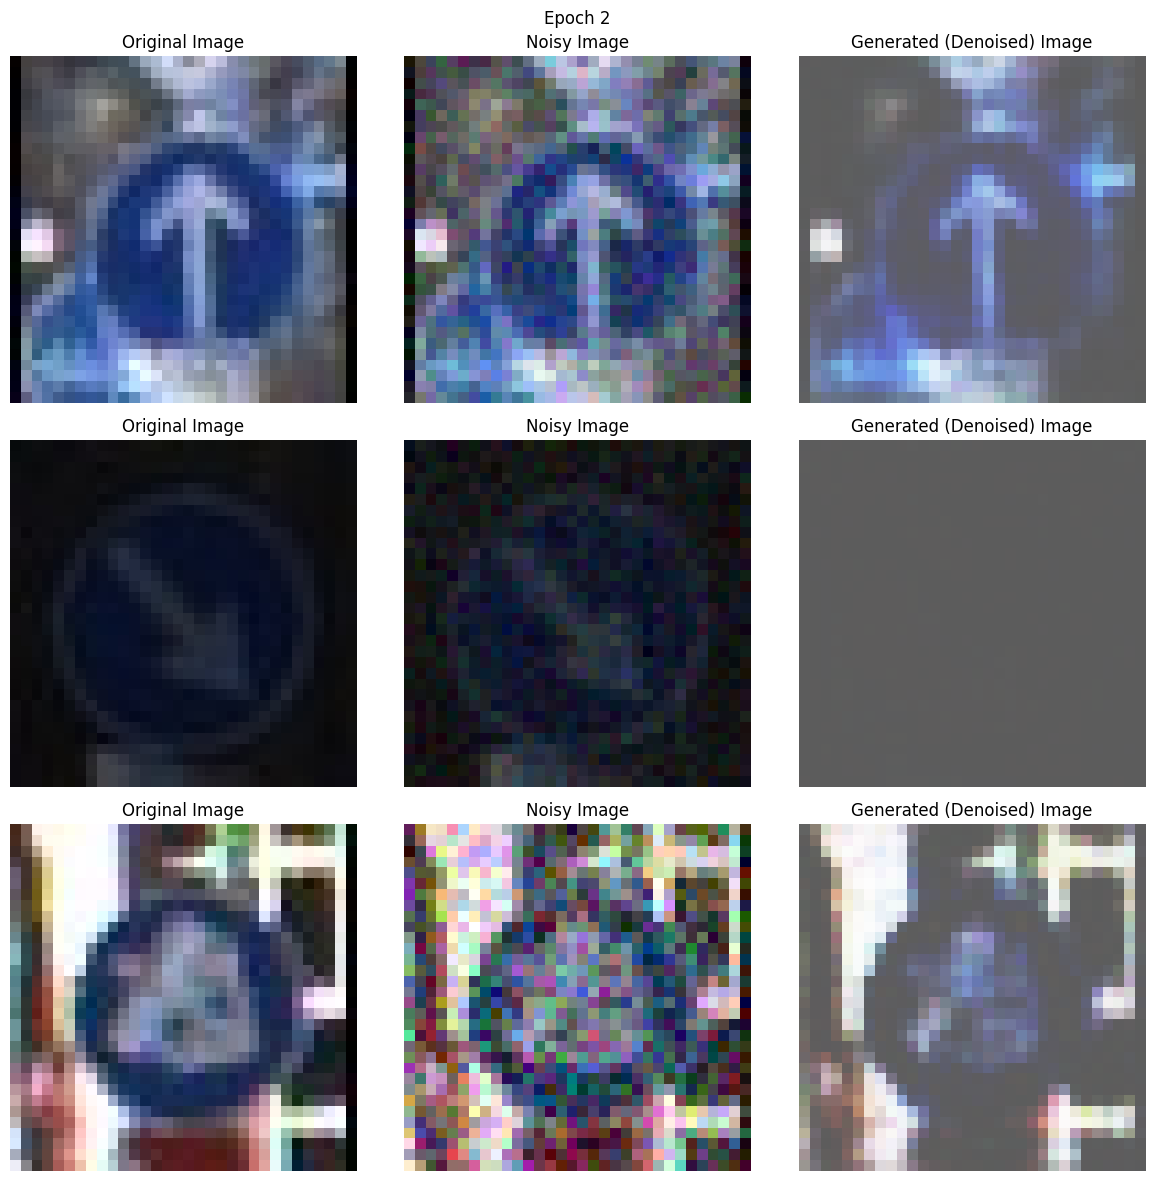

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.58it/s]


Finished epoch 3. Average loss for this epoch: 0.155221
Sample 1:
Tensor min: -1.0000, max: -0.0588
Tensor min: -1.0000, max: 0.4722
Tensor min: -0.2715, max: -0.1795
Sample 2:
Tensor min: -1.0000, max: -0.3412
Tensor min: -1.0000, max: -0.2309
Tensor min: -0.2715, max: -0.2636
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9827


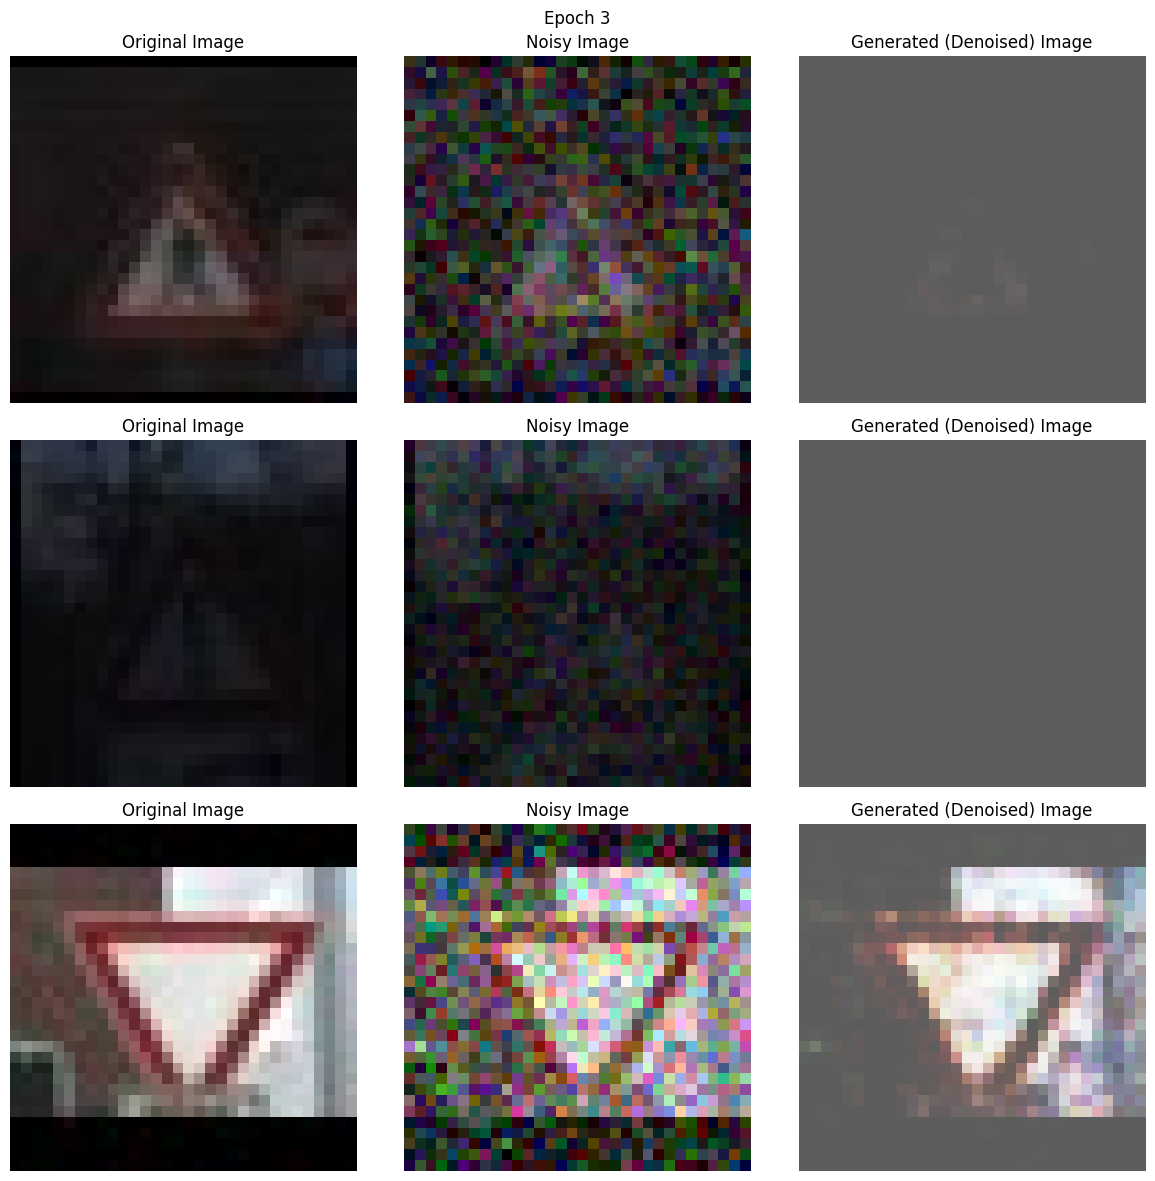

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.57it/s]


Finished epoch 4. Average loss for this epoch: 0.154615
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9959
Sample 2:
Tensor min: -1.0000, max: -0.0745
Tensor min: -1.0000, max: 0.0759
Tensor min: -0.2715, max: -0.1246
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9880


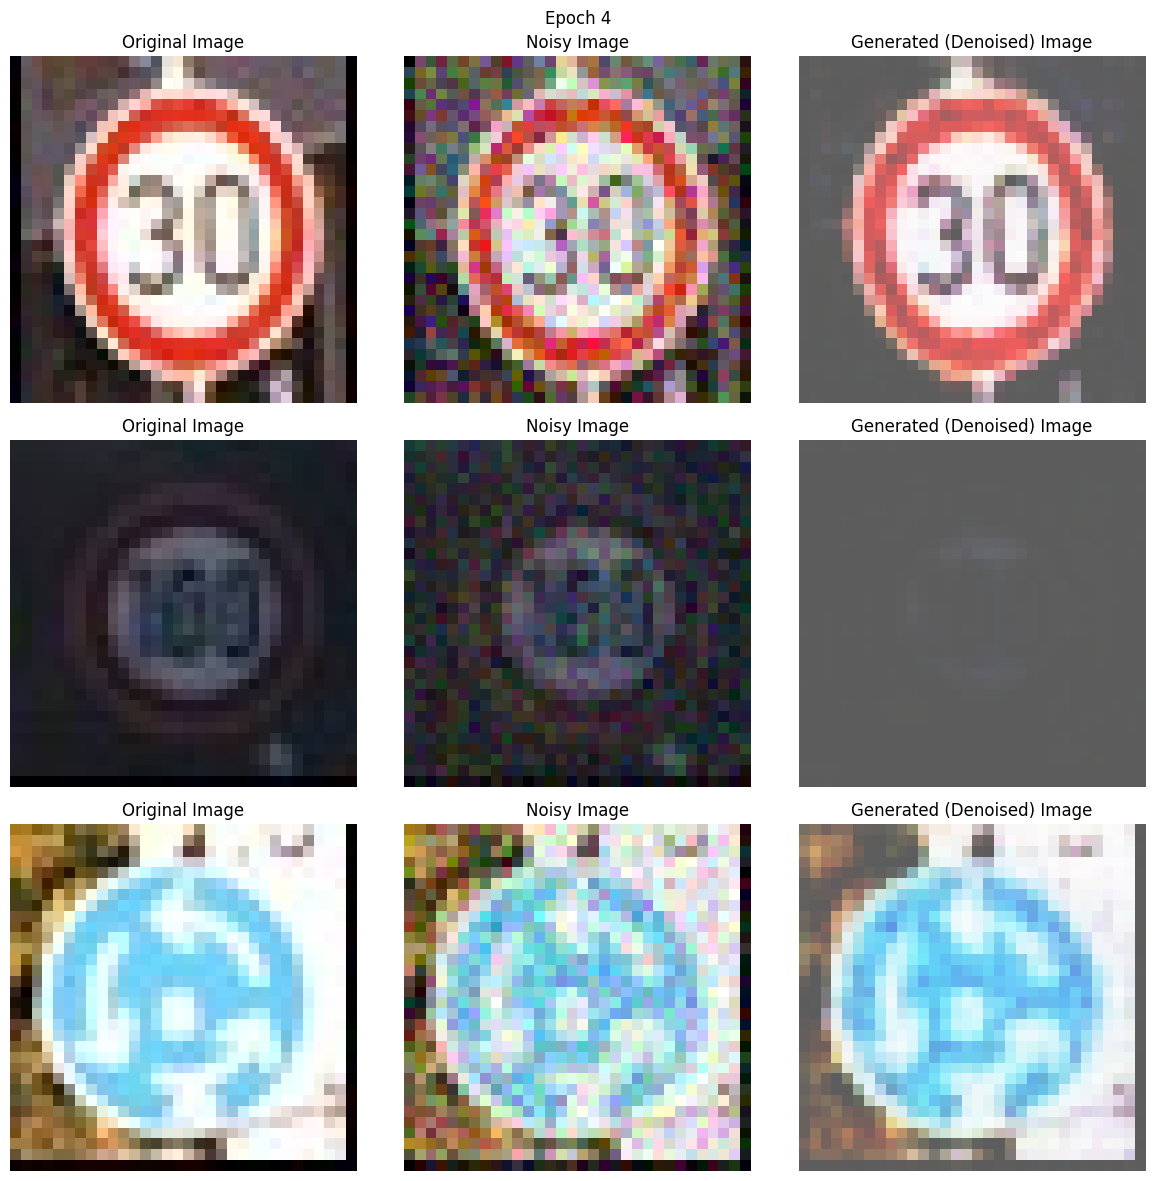

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.56it/s]


Finished epoch 5. Average loss for this epoch: 0.154344
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9954
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9995
Sample 3:
Tensor min: -1.0000, max: 0.6549
Tensor min: -1.0000, max: 0.6277
Tensor min: -0.2715, max: 0.8080


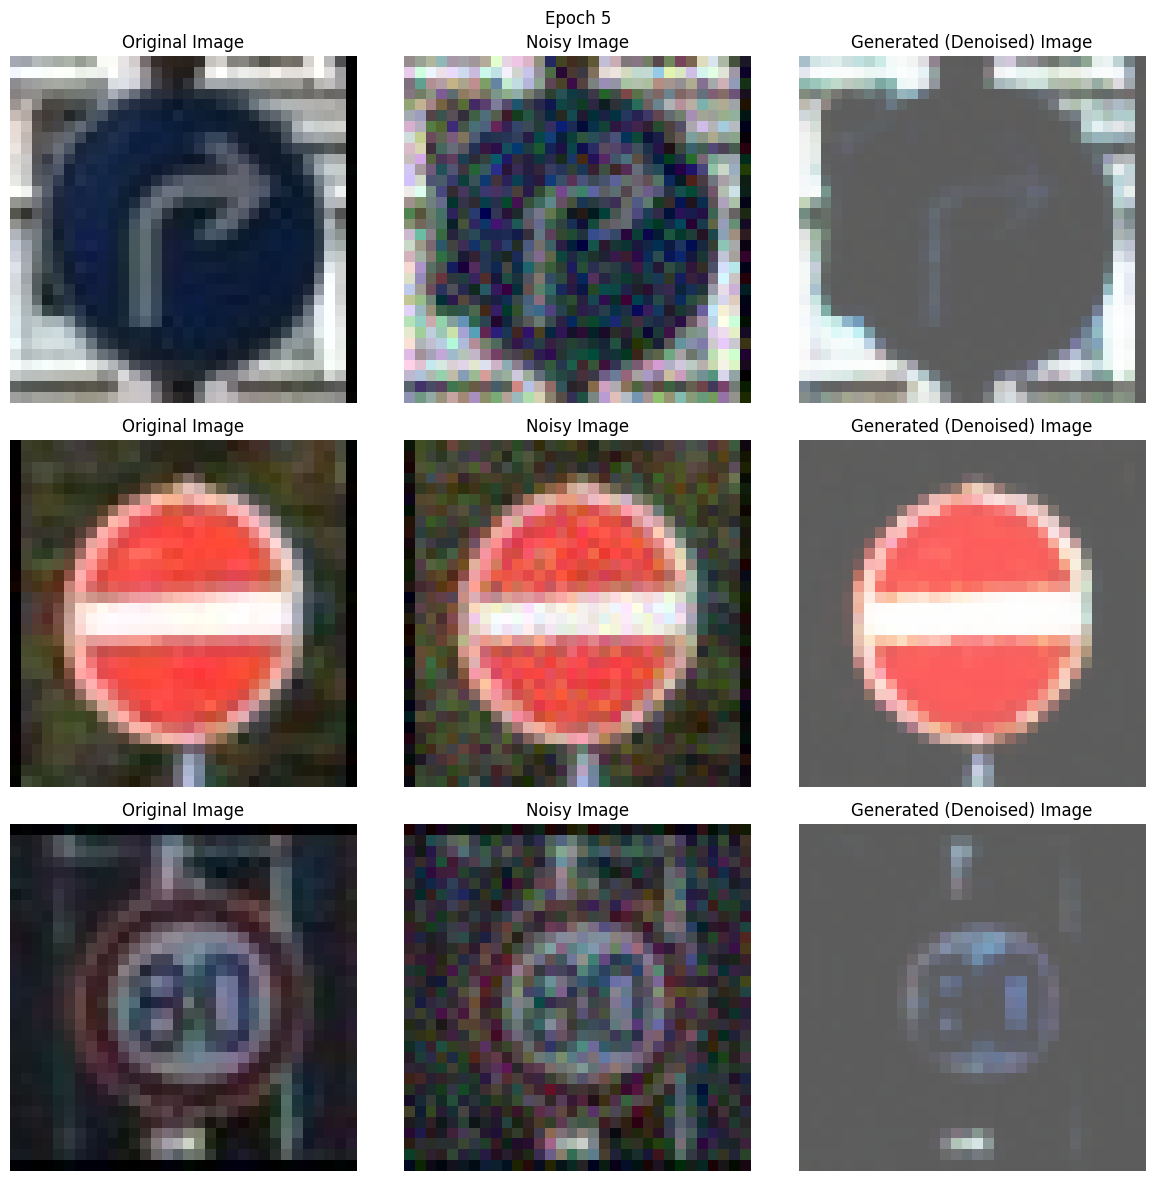

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.20it/s]


Finished epoch 6. Average loss for this epoch: 0.154040
Sample 1:
Tensor min: -1.0000, max: 0.4275
Tensor min: -1.0000, max: 0.4083
Tensor min: -0.2715, max: 0.4846
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9751
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9748


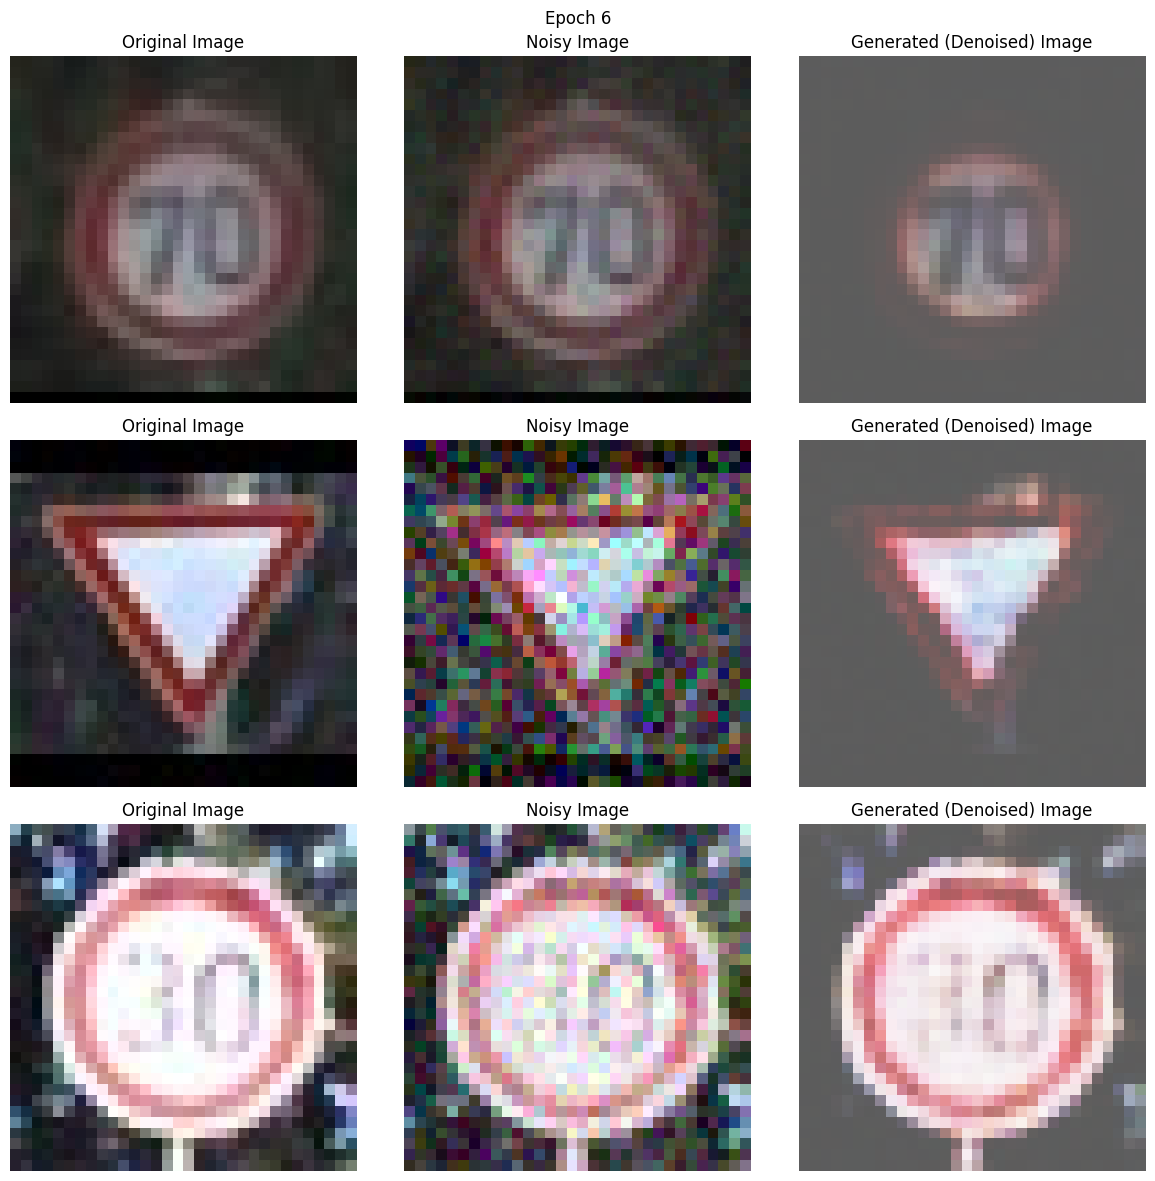

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.31it/s]


Finished epoch 7. Average loss for this epoch: 0.153865
Sample 1:
Tensor min: -1.0000, max: -0.2314
Tensor min: -1.0000, max: 0.6169
Tensor min: -0.2715, max: -0.2456
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9968
Sample 3:
Tensor min: -1.0000, max: 0.2157
Tensor min: -1.0000, max: 0.2913
Tensor min: -0.2715, max: 0.2945


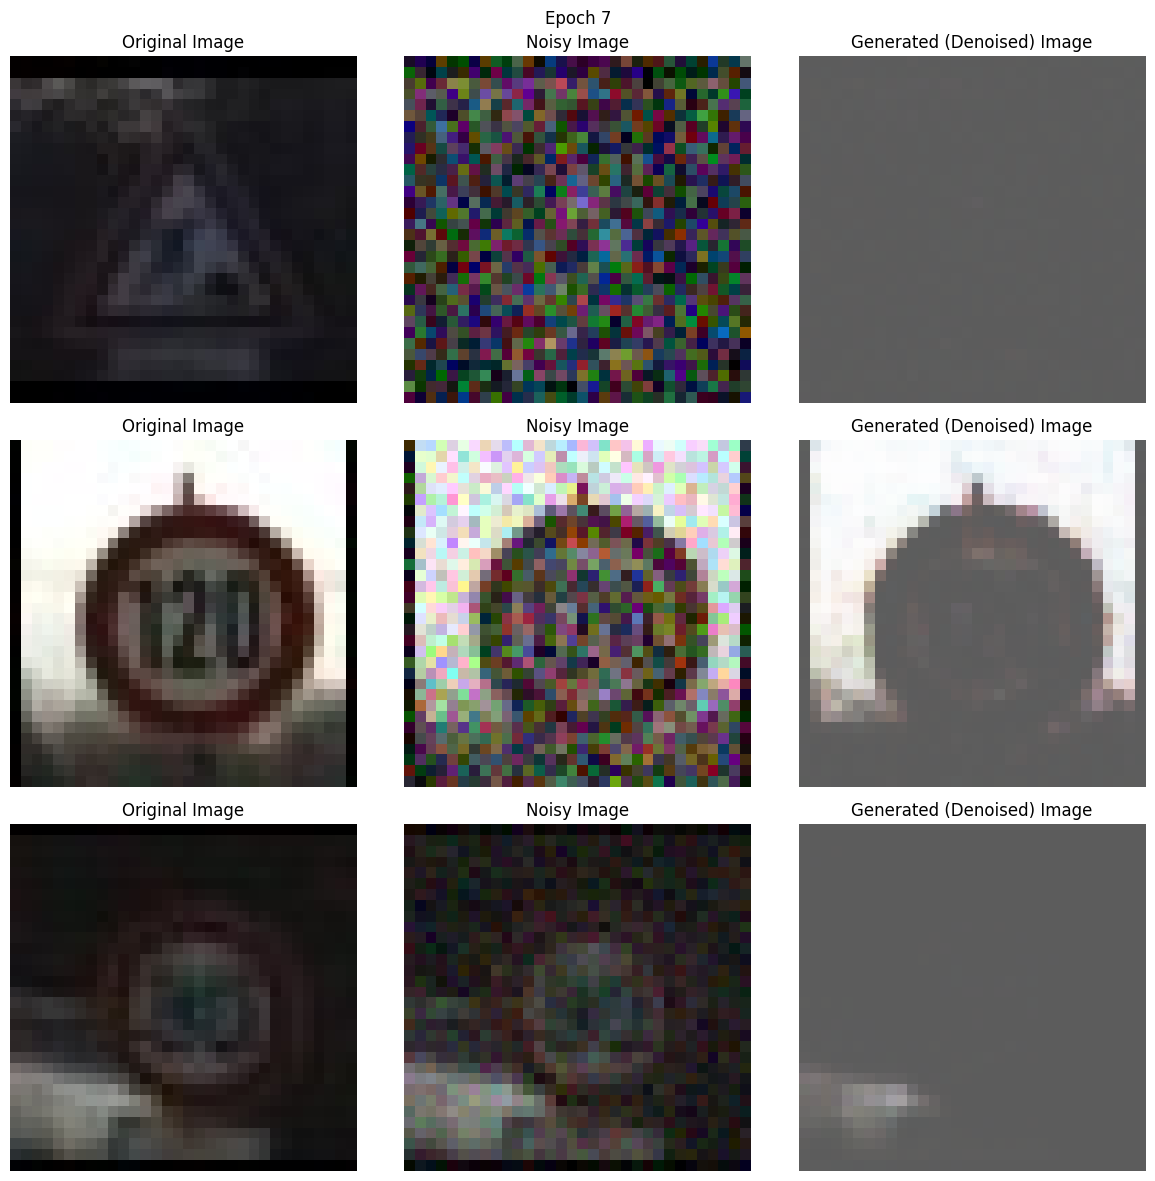

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.62it/s]


Finished epoch 8. Average loss for this epoch: 0.153773
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9969
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9980
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9743


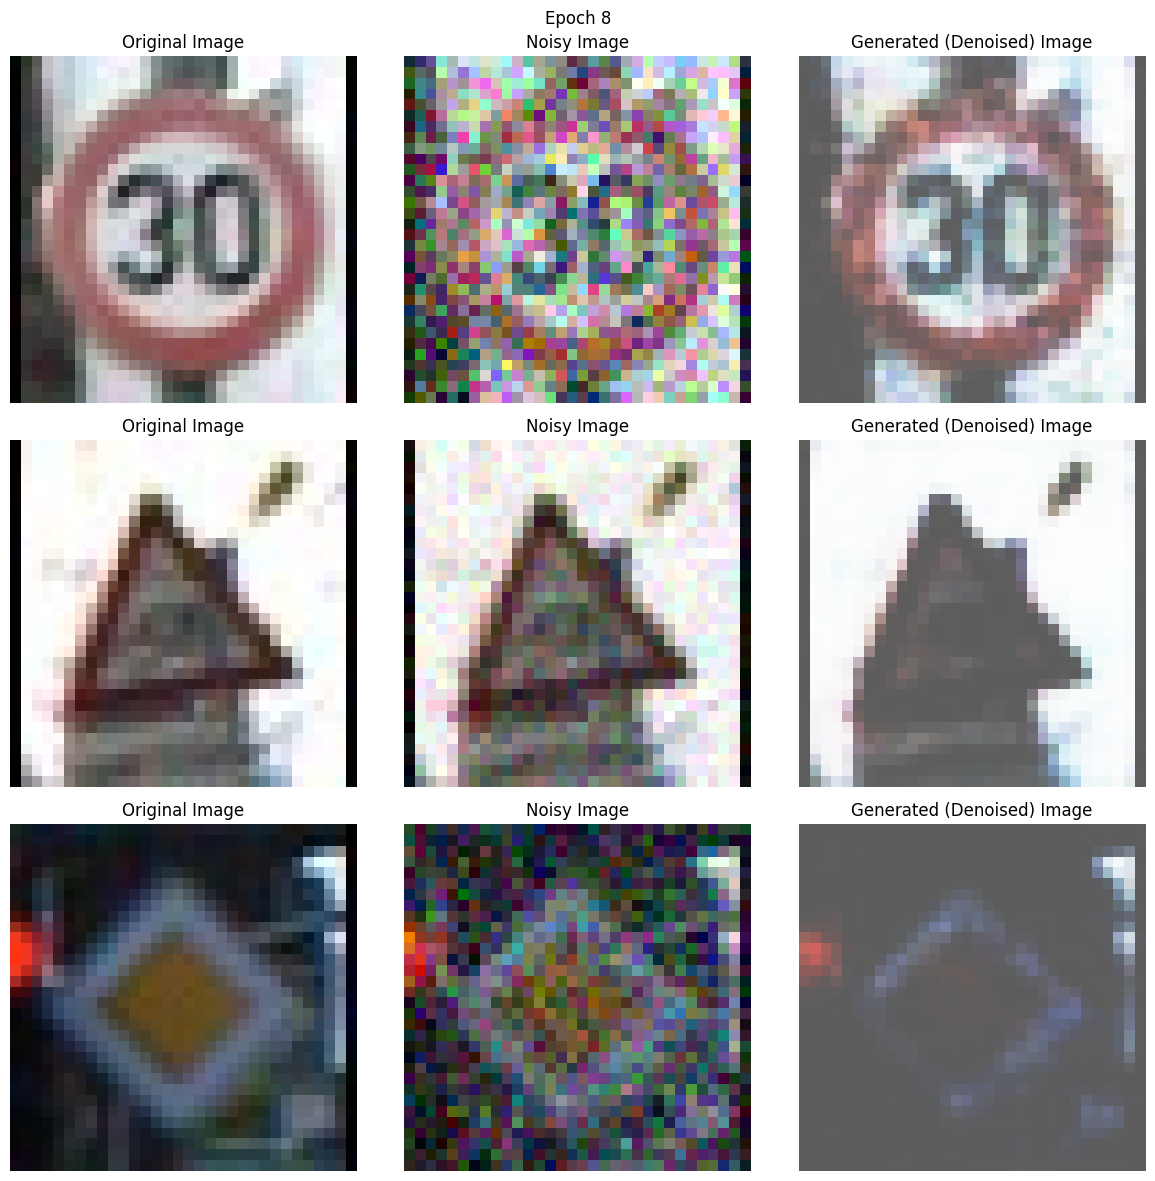

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.36it/s]


Finished epoch 9. Average loss for this epoch: 0.153663
Sample 1:
Tensor min: -1.0000, max: -0.1451
Tensor min: -1.0000, max: -0.1418
Tensor min: -0.2715, max: -0.2164
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9646
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9435


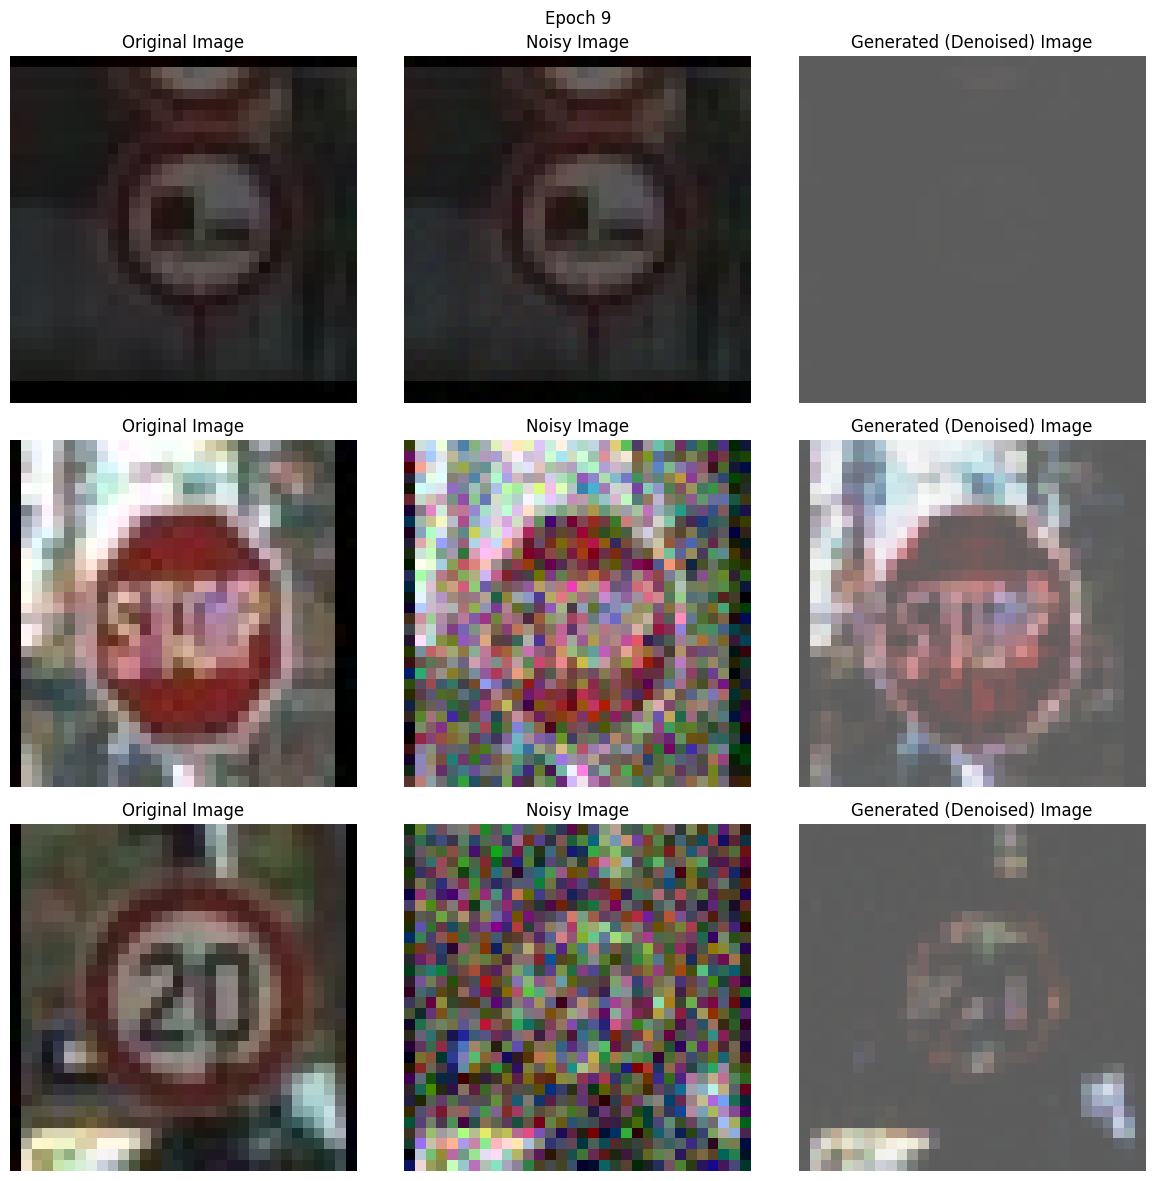

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.76it/s]


Finished epoch 10. Average loss for this epoch: 0.153570
Sample 1:
Tensor min: -0.9843, max: -0.7569
Tensor min: -1.0000, max: -0.0701
Tensor min: -0.2715, max: -0.2669
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9917
Sample 3:
Tensor min: -1.0000, max: -0.2078
Tensor min: -1.0000, max: -0.0630
Tensor min: -0.2715, max: -0.2451


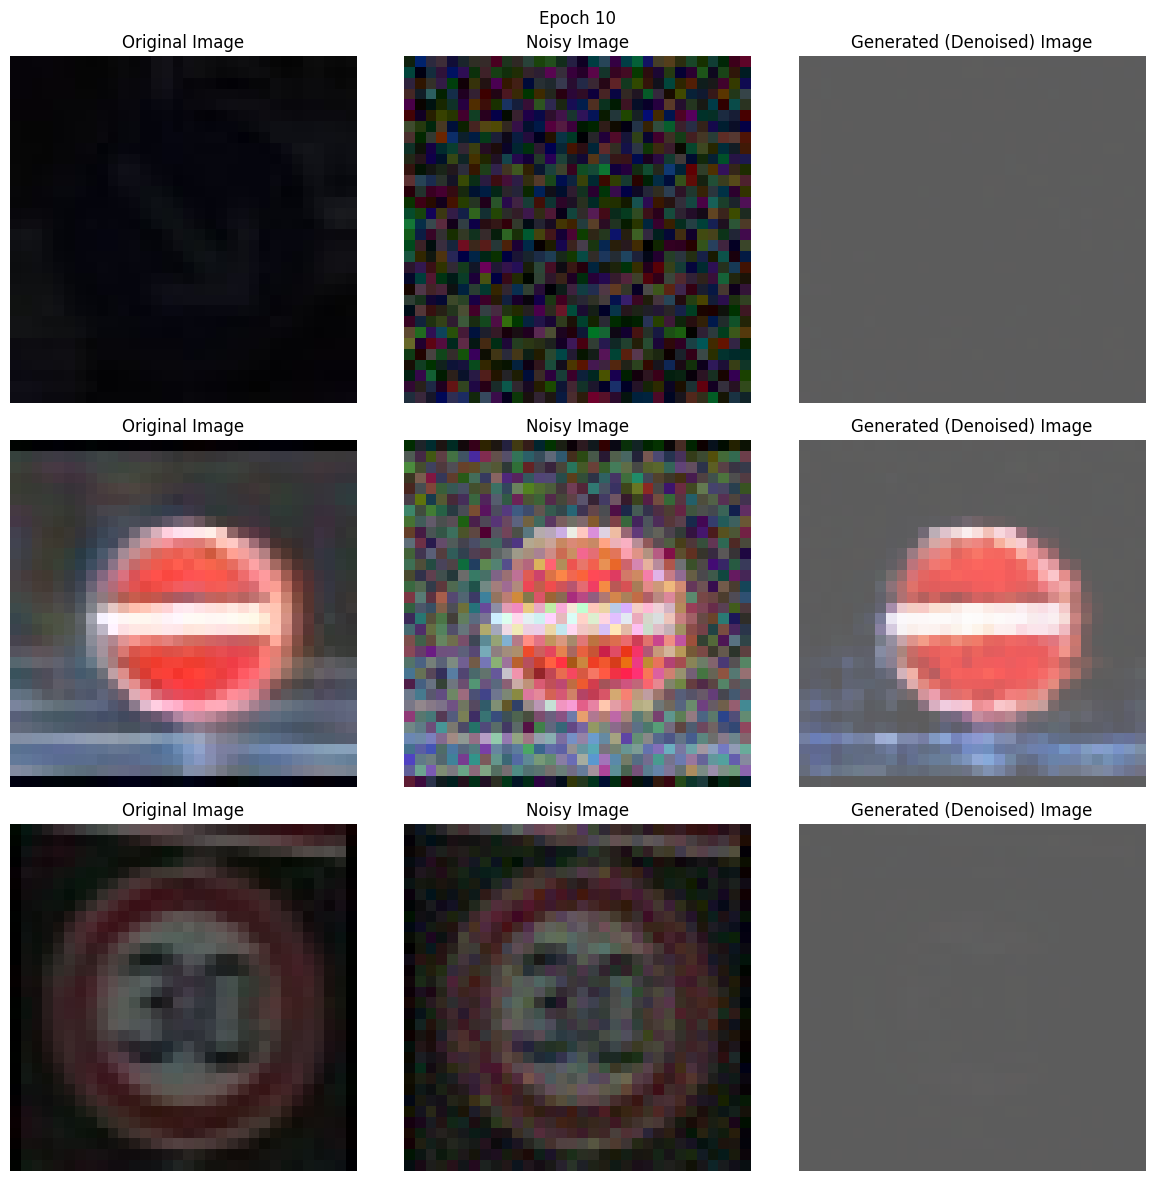

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.86it/s]


Finished epoch 11. Average loss for this epoch: 0.153409
Sample 1:
Tensor min: -1.0000, max: 0.7412
Tensor min: -1.0000, max: 0.8482
Tensor min: -0.2715, max: 0.8352
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9890
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9707


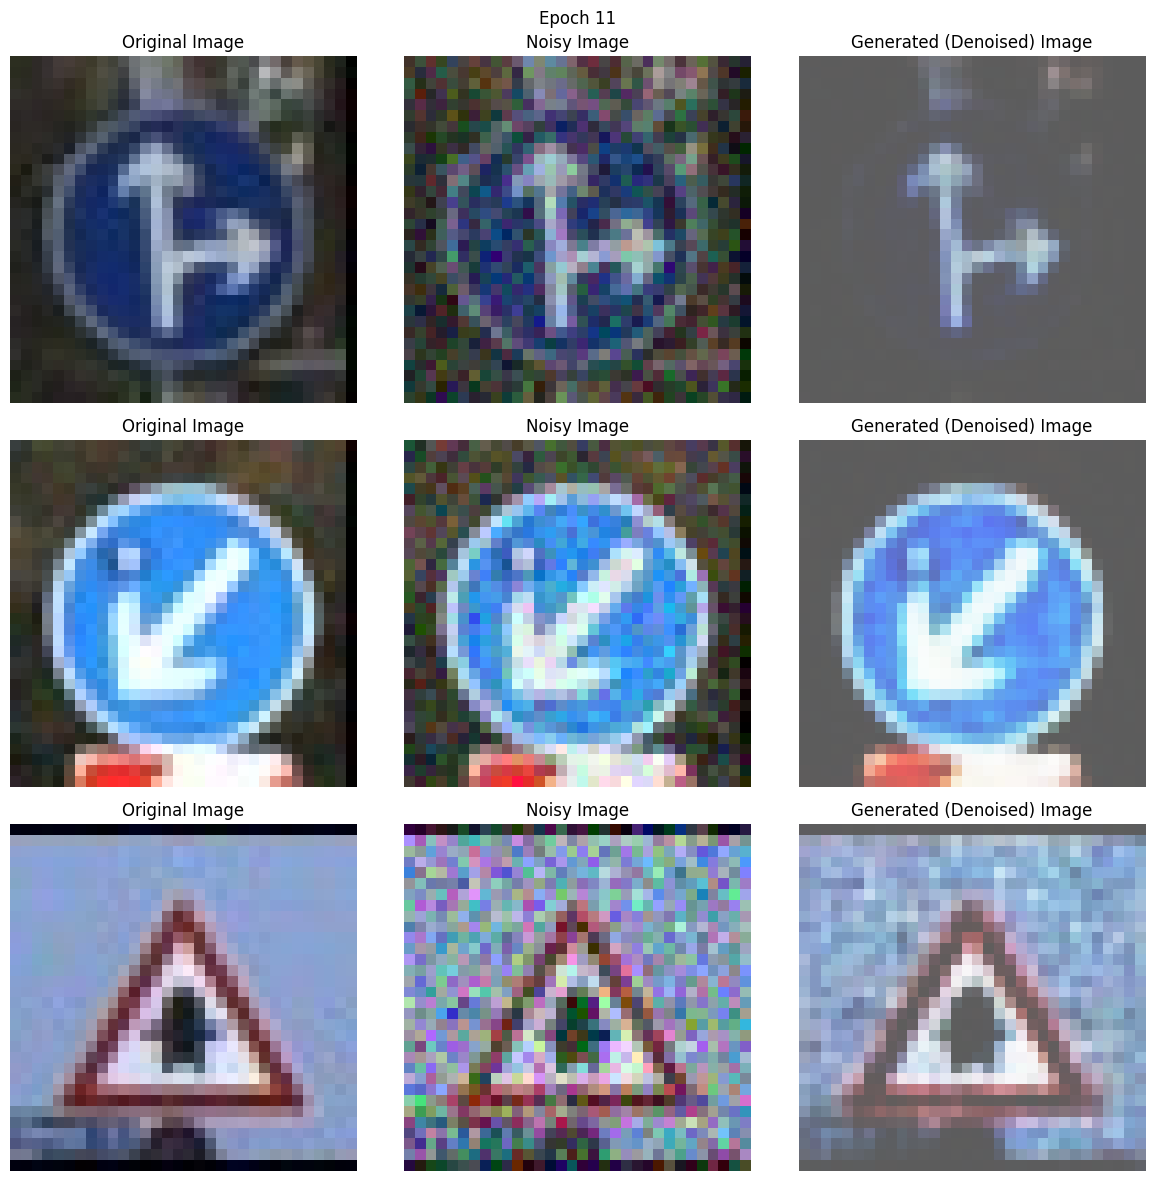

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.03it/s]


Finished epoch 12. Average loss for this epoch: 0.153324
Sample 1:
Tensor min: -1.0000, max: 0.3098
Tensor min: -1.0000, max: 0.7814
Tensor min: -0.2715, max: 0.5005
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9863
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9970


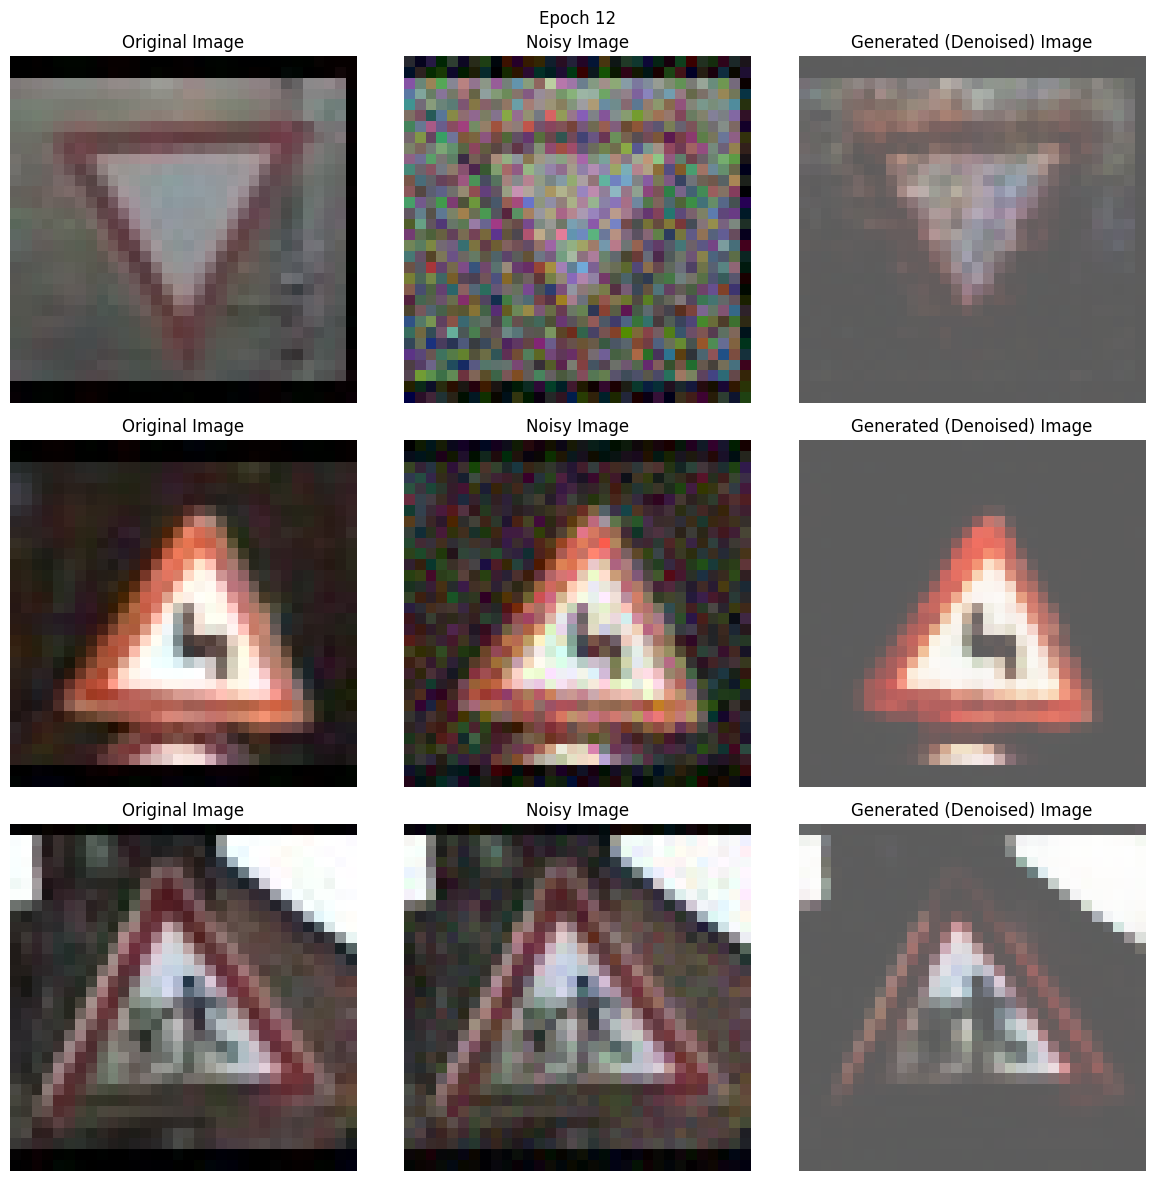

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:22<00:00, 24.15it/s]


Finished epoch 13. Average loss for this epoch: 0.153266
Sample 1:
Tensor min: -1.0000, max: -0.0039
Tensor min: -1.0000, max: 0.4550
Tensor min: -0.2715, max: 0.1460
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9599
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9948


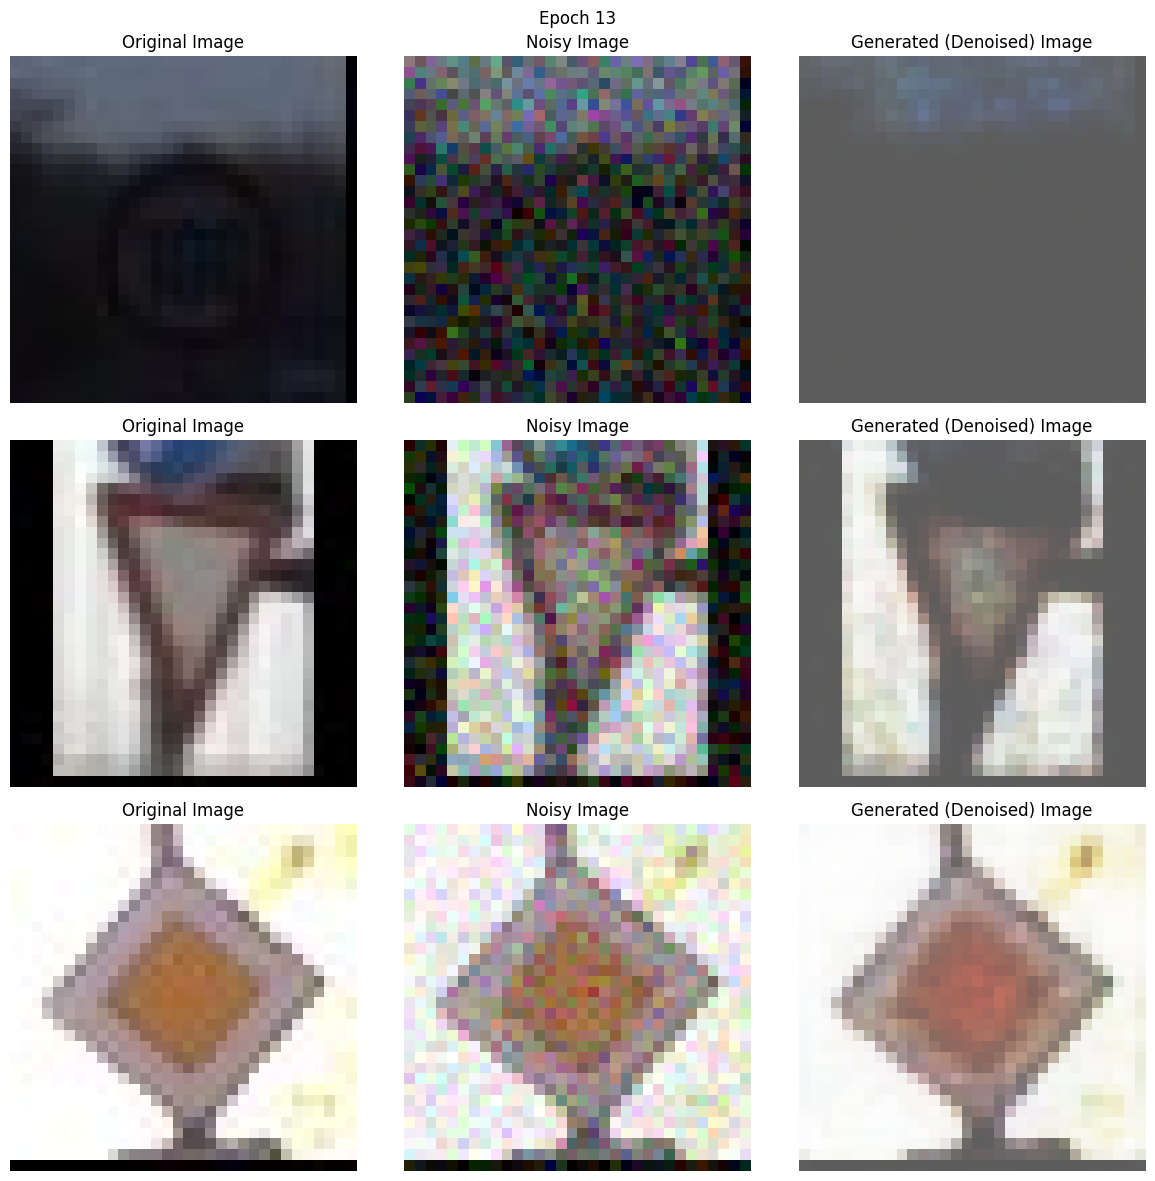

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.37it/s]


Finished epoch 14. Average loss for this epoch: 0.153193
Sample 1:
Tensor min: -1.0000, max: -0.4196
Tensor min: -1.0000, max: 0.3101
Tensor min: -0.2715, max: -0.2651
Sample 2:
Tensor min: -1.0000, max: -0.0745
Tensor min: -1.0000, max: 0.3550
Tensor min: -0.2715, max: -0.1789
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9945


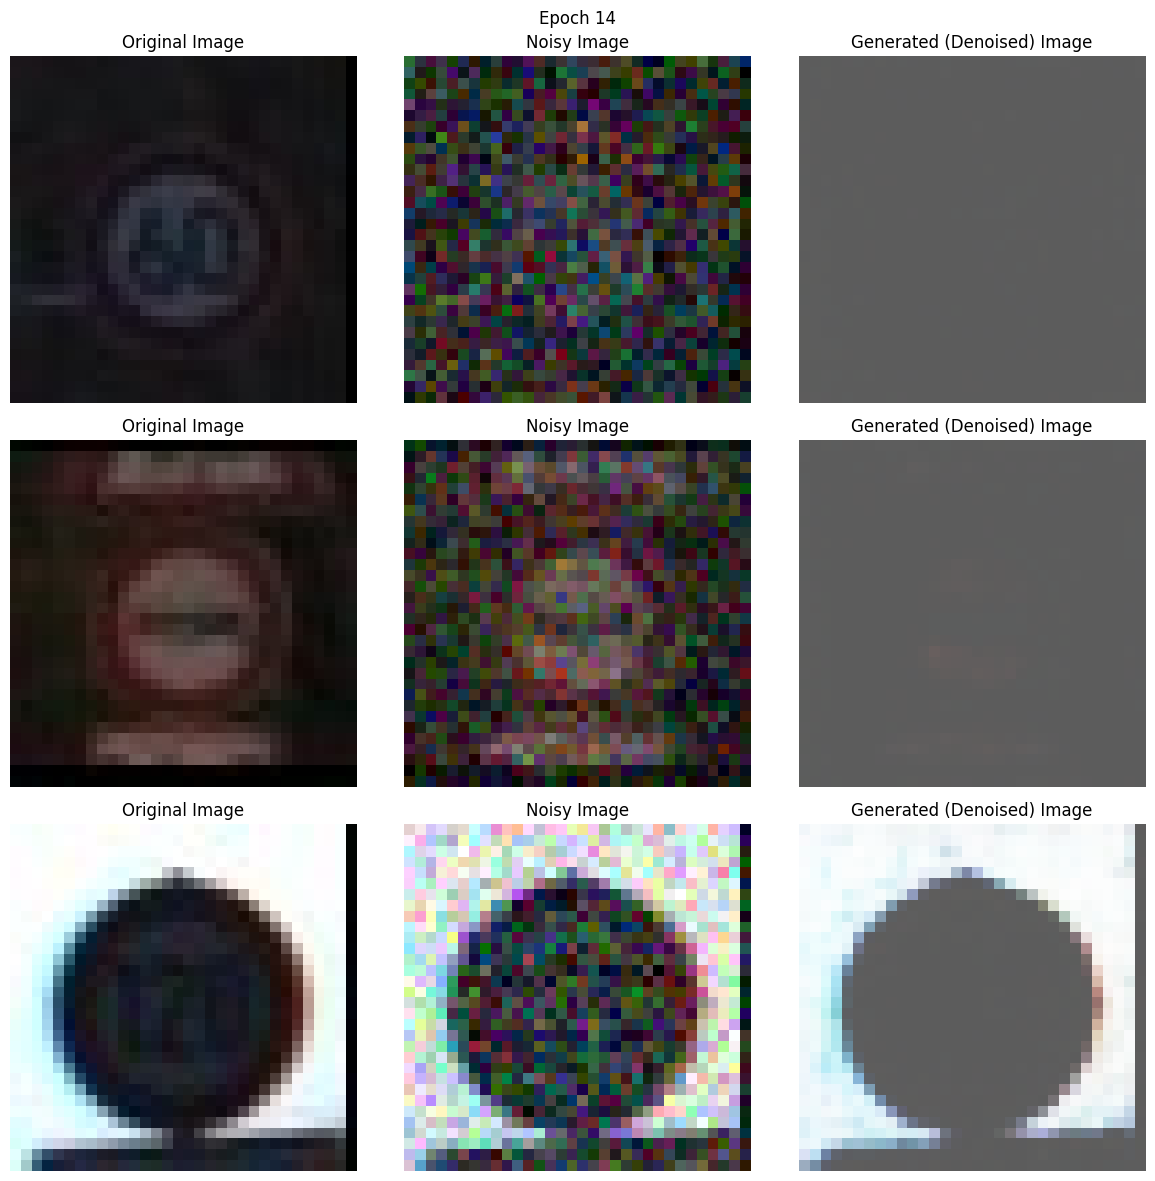

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.13it/s]


Finished epoch 15. Average loss for this epoch: 0.153153
Sample 1:
Tensor min: -1.0000, max: 0.6784
Tensor min: -1.0000, max: 0.6839
Tensor min: -0.2715, max: 0.7515
Sample 2:
Tensor min: -1.0000, max: -0.0431
Tensor min: -1.0000, max: 0.7008
Tensor min: -0.2715, max: -0.1047
Sample 3:
Tensor min: -1.0000, max: -0.6941
Tensor min: -1.0000, max: -0.2192
Tensor min: -0.2715, max: -0.2696


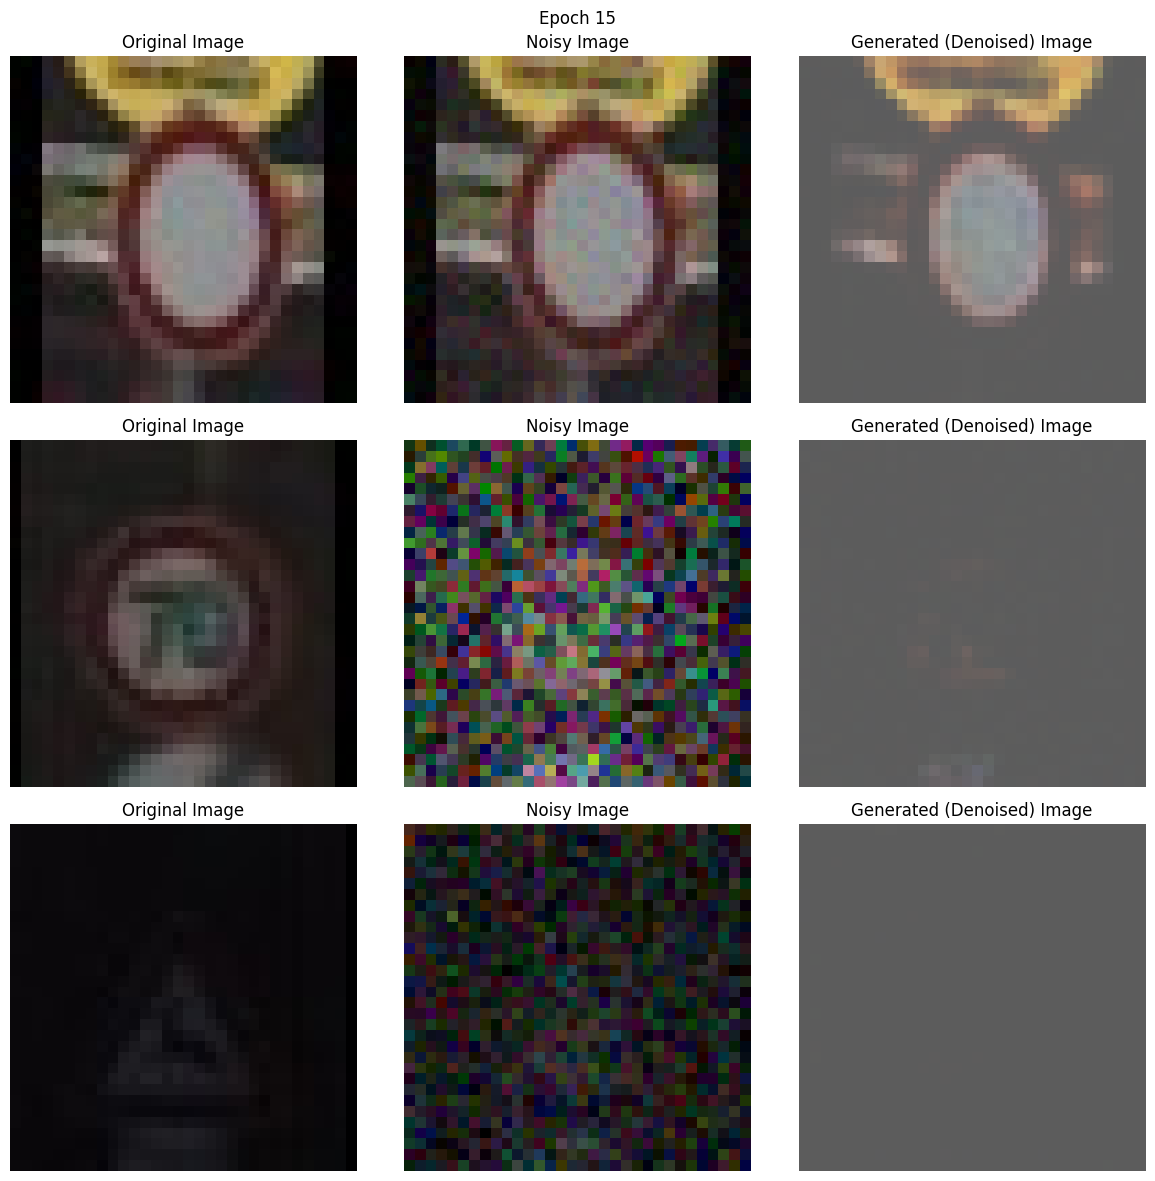

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.41it/s]


Finished epoch 16. Average loss for this epoch: 0.153083
Sample 1:
Tensor min: -0.9843, max: 0.5216
Tensor min: -1.0000, max: 0.6184
Tensor min: -0.2715, max: 0.5526
Sample 2:
Tensor min: -1.0000, max: 0.9059
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.7910
Sample 3:
Tensor min: -1.0000, max: 0.1608
Tensor min: -1.0000, max: 0.5499
Tensor min: -0.2715, max: -0.2269


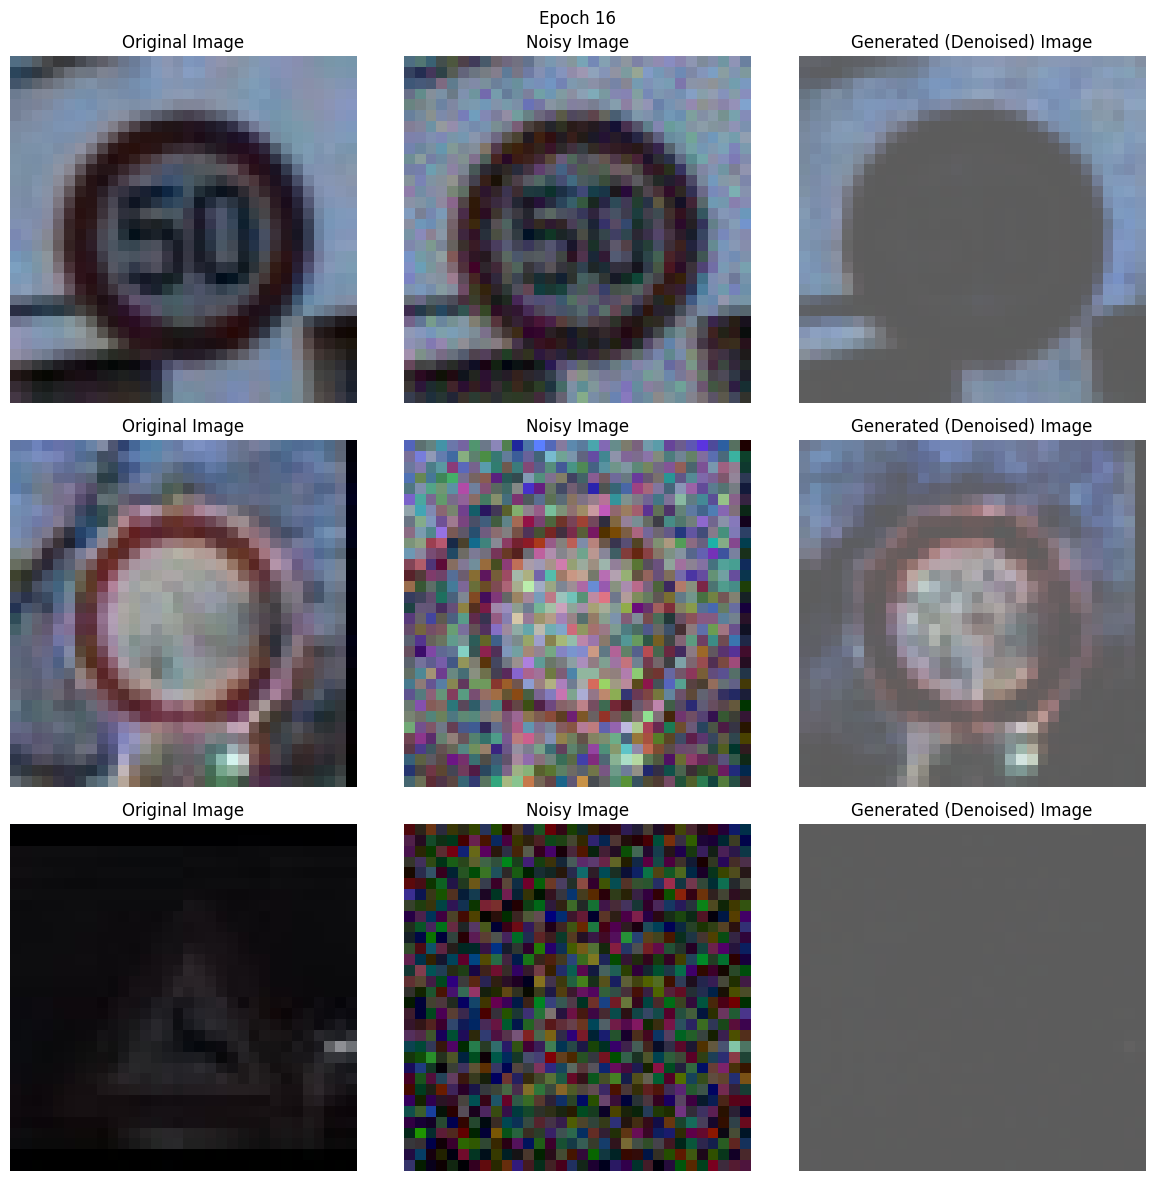

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.46it/s]


Finished epoch 17. Average loss for this epoch: 0.153019
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 0.9127
Tensor min: -0.2715, max: 0.6180
Sample 2:
Tensor min: -1.0000, max: 0.2549
Tensor min: -1.0000, max: 0.5303
Tensor min: -0.2715, max: -0.1087
Sample 3:
Tensor min: -0.9529, max: 0.5451
Tensor min: -1.0000, max: 0.6678
Tensor min: -0.2715, max: 0.4186


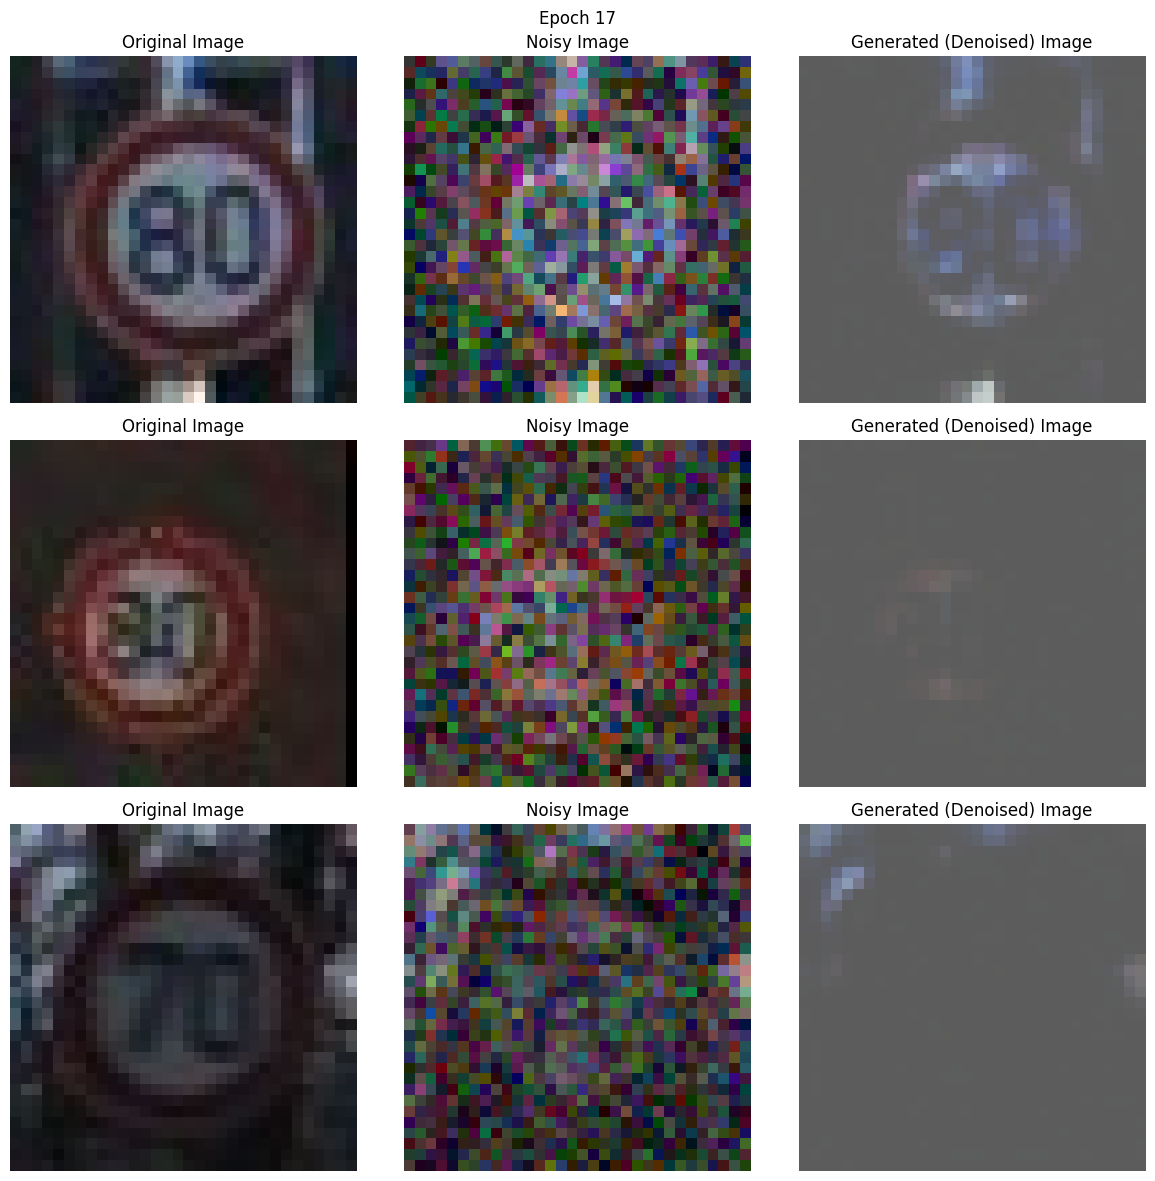

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.22it/s]


Finished epoch 18. Average loss for this epoch: 0.152949
Sample 1:
Tensor min: -1.0000, max: -0.1137
Tensor min: -1.0000, max: -0.0384
Tensor min: -0.2715, max: -0.1970
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9904
Sample 3:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9843


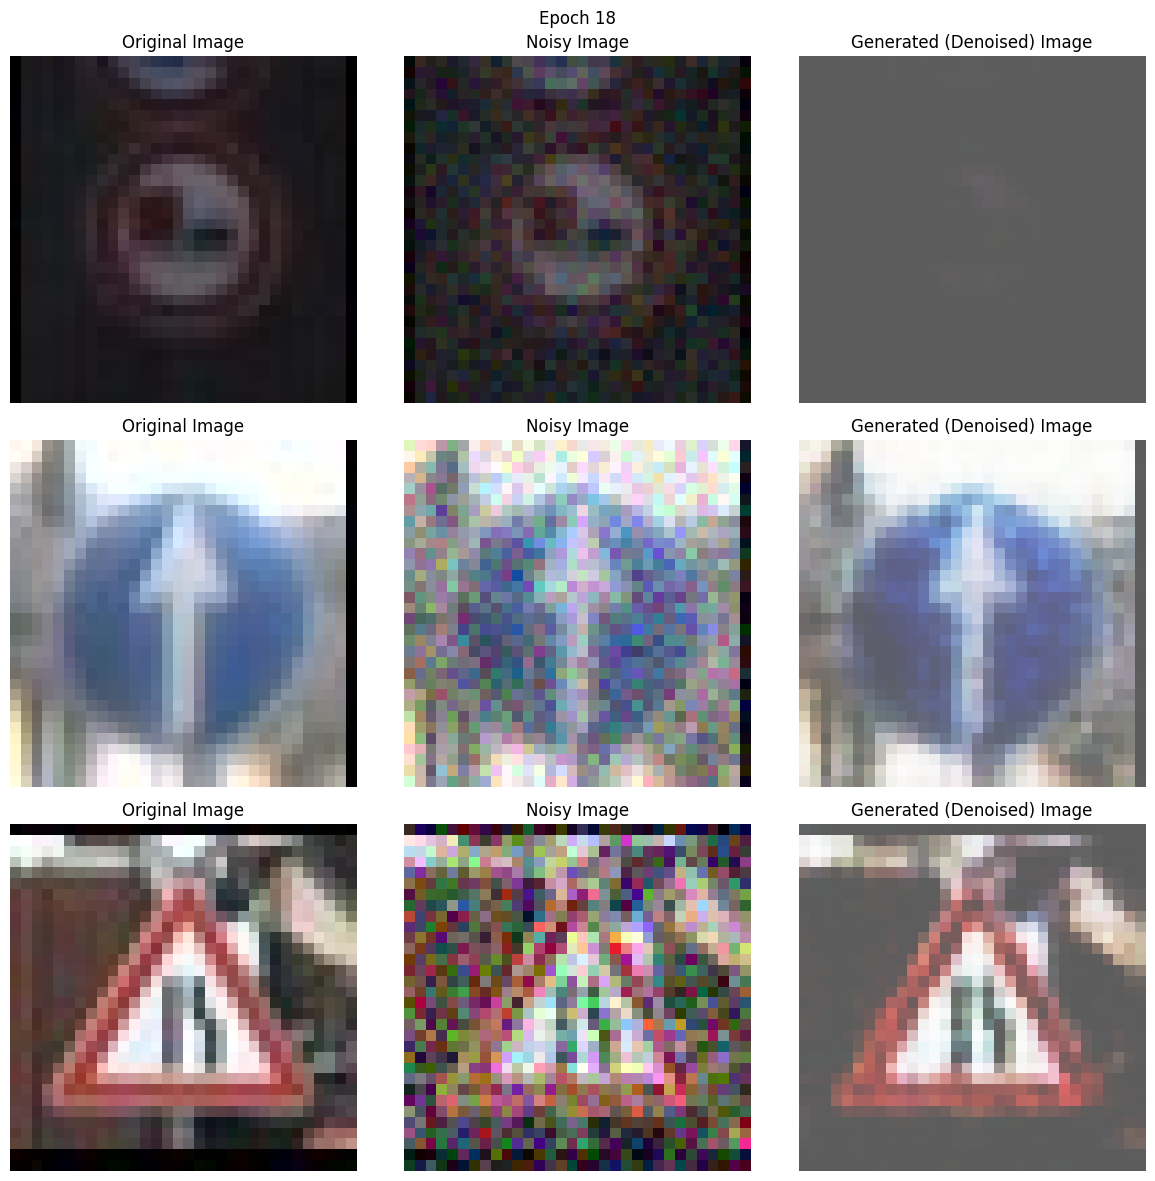

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:23<00:00, 23.51it/s]


Finished epoch 19. Average loss for this epoch: 0.152951
Sample 1:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9944
Sample 2:
Tensor min: -1.0000, max: 1.0000
Tensor min: -1.0000, max: 1.0000
Tensor min: -0.2715, max: 0.9498
Sample 3:
Tensor min: -1.0000, max: -0.4667
Tensor min: -1.0000, max: 0.0350
Tensor min: -0.2715, max: -0.2693


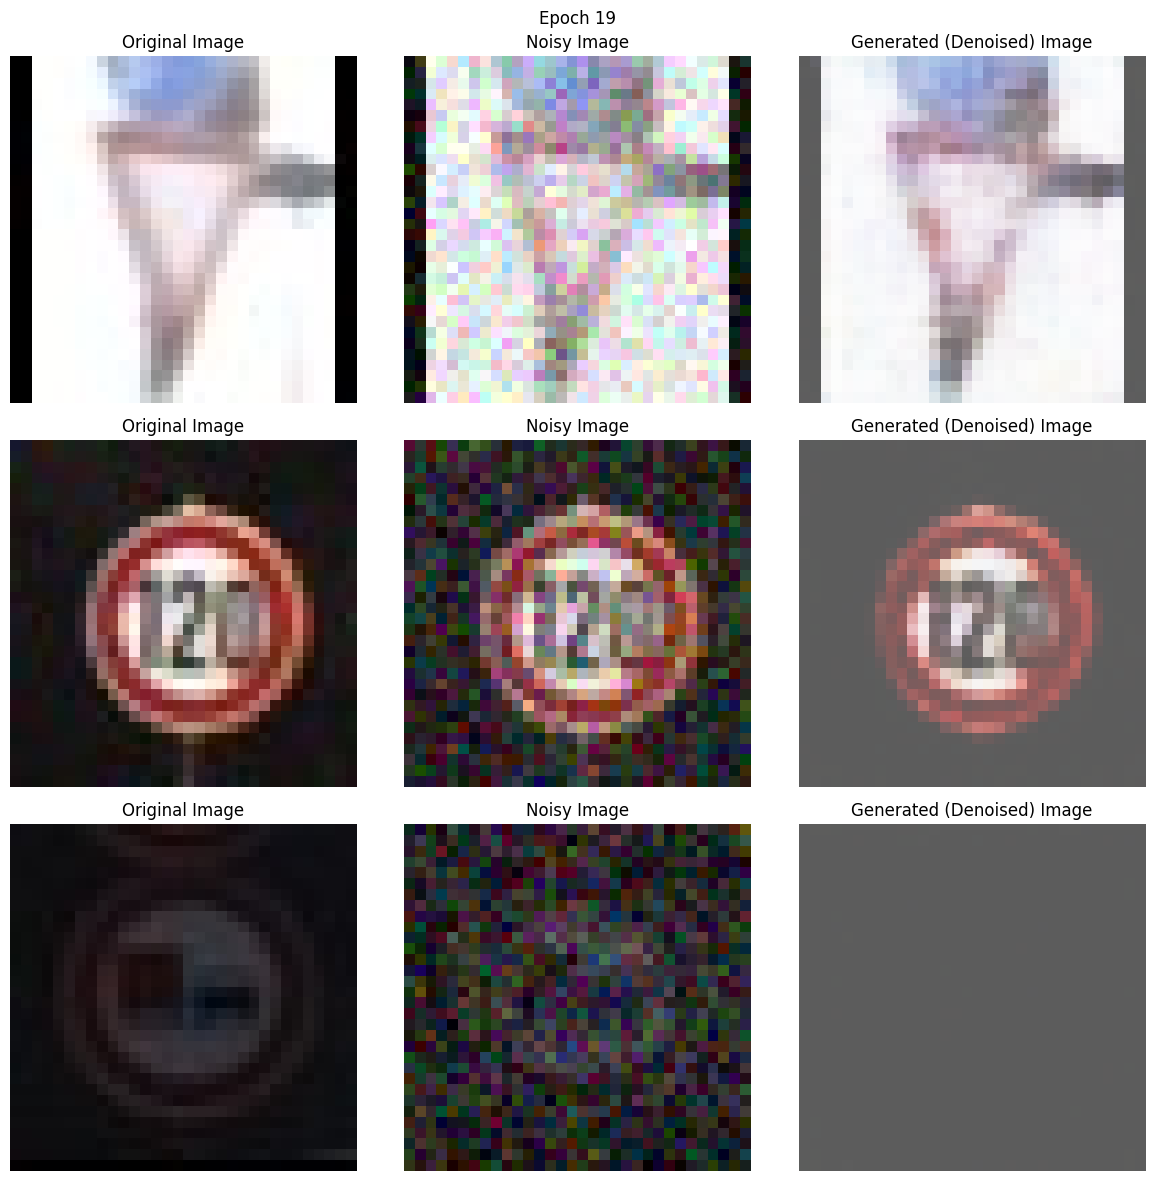

In [17]:
n_epochs = 20

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

for epoch in range(n_epochs):

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, y, noise_amount)

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    with torch.no_grad():
        num_samples = min(3, x.shape[0])
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = [axes]

        for i in range(num_samples):
            original = x[i]
            noisy = noisy_x[i]
            generated = pred[i]

            print(f"Sample {i+1}:")
            original_img = tensor_to_image(original, normalize=True)
            noisy_img = tensor_to_image(noisy, normalize=True)
            generated_img = tensor_to_image(generated, normalize=True)

            axes[i][0].imshow(original_img)
            axes[i][0].set_title('Original Image')
            axes[i][0].axis('off')

            axes[i][1].imshow(noisy_img)
            axes[i][1].set_title('Noisy Image')
            axes[i][1].axis('off')

            axes[i][2].imshow(generated_img)
            axes[i][2].set_title('Generated (Denoised) Image')
            axes[i][2].axis('off')

        plt.suptitle(f'Epoch {epoch}')
        plt.tight_layout()
        plt.show()

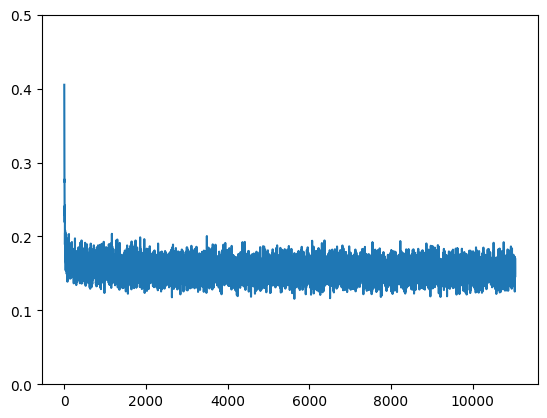

In [18]:
plt.plot(losses)
plt.ylim(0, 0.5);

In [19]:
import torch
import torchvision.transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm

fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

transform = T.Compose([
    T.Resize((299, 299)),
    T.Normalize((0.5,), (0.5,)) if x.shape[1] == 1 else T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

net.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader):
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)
        pred = net(noisy_x, y, noise_amount)

        for real_img, gen_img in zip(x, pred):
            real_img = transform(real_img).unsqueeze(0)
            gen_img = transform(gen_img).unsqueeze(0)
            fid.update(real_img, real=True)
            fid.update(gen_img, real=False)

fid_score = fid.compute()
print(f"FID score: {fid_score.item():.4f}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [01:48<00:00,  1.76s/it]


FID score: 102.8956


In [20]:
torch.save(net.state_dict(), 'unet-82-fid.pth')